In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import gc
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.constraints import Constraint
import tensorflow.keras.backend as K

gc.enable()

In [2]:
dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
root_dir = os.path.join(data_dir, "BSDS500/data")

70763455/70763455 [==============================] - 5s 0us/step


In [3]:
test_paths = glob(root_dir + "/images/test/" + "*.jpg")

In [25]:
crop_size = 96 * 2  # HR size
upscale_factor = 4
input_size = crop_size // upscale_factor
batch_size = 16
AUTOTUNE = tf.data.AUTOTUNE

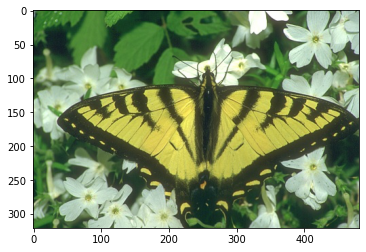

In [5]:
image = Image.open(root_dir + "/images/train/35010.jpg")
plt.imshow(image)

In [26]:
train = tf.keras.utils.image_dataset_from_directory(
    root_dir,
    batch_size=None,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=42,
    label_mode=None,
)

valid = tf.keras.utils.image_dataset_from_directory(
    root_dir,
    batch_size=None,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=42,
    label_mode=None,
)

Found 500 files belonging to 1 classes.
Using 400 files for training.
Found 500 files belonging to 1 classes.
Using 100 files for validation.


In [27]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(input_size, input_size, interpolation='area'),
    # layers.Rescaling(1./255)
    layers.Rescaling(1./127.5, offset=-1)  # [-1,1]
])

rescale = tf.keras.Sequential([
    # layers.Rescaling(1./255)
    layers.Rescaling(1./127.5, offset=-1)
])

data_augmentation = tf.keras.Sequential([
        layers.RandomCrop(crop_size, crop_size),
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
])

def prepare(ds, shuffle=False, augment=False):
    if augment:
        ds = ds.map(lambda x: (data_augmentation(x, training=True)), num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x: (resize_and_rescale(x), rescale(x)), num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    ds = ds.batch(batch_size)

    return ds.prefetch(buffer_size=AUTOTUNE)

In [8]:
# helper functions

def psnr(x1, x2):
    return tf.image.psnr(x1, x2, max_val=255)  # 255 for model output range [0,255]

def denormalize(inputs):  # from [0,1]
    return tf.cast(tf.clip_by_value(inputs * 255, 0, 255), dtype=tf.uint8)

def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)

In [9]:
def denormalize(inputs):  # from [-1,1]
    return tf.cast(tf.clip_by_value((inputs * 0.5 + 0.5) * 255, 0, 255), dtype=tf.uint8)

In [28]:
train_ds = prepare(train, shuffle=True, augment=True)
valid_ds = prepare(valid)

In [29]:
for p in train_ds.take(1):
    ims, tars = p

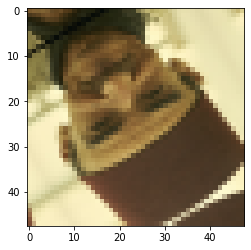

In [30]:
plt.imshow(denormalize(ims[0]).numpy())

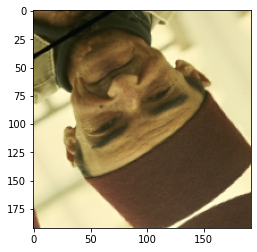

In [31]:
plt.imshow(denormalize(tars[0]).numpy())

In [32]:
# vgg19 model for computing loss

def vgg_model():
    
    vgg19 = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(crop_size, crop_size, 3))
    #vgg19.trainable = False
    #for layer in vgg19.layers:
    #    layer.trainable = False
    model = tf.keras.Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)  # [14,14,512]
    model.trainable = False  # was True

    return model

def perceptual_loss(model):

    def loss(y_true, y_pred):
        y_true_ = tf.cast(denormalize(y_true), dtype=tf.float32)  # set in range [0,255] as expected by vgg19
        y_pred_ = tf.cast(denormalize(y_pred), dtype=tf.float32)
        y_true_ = tf.keras.applications.vgg19.preprocess_input(y_true_)  # preprocess batch for vgg19
        y_pred_ = tf.keras.applications.vgg19.preprocess_input(y_pred_)

        return K.mean(K.square(model(y_true_) - model(y_pred_)))  # MSE loss
    
    return loss

In [33]:
# generator

def generator():
    def residual_block(inputs, filters):
        out = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(inputs)
        out = layers.BatchNormalization(momentum=0.8)(out)
        out = layers.PReLU(shared_axes=[1,2])(out)
        out = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(out)
        out = layers.BatchNormalization(momentum=0.8)(out)
        out = layers.Add()([inputs, out])
        return out

    def upsample(inputs):
        out = layers.Conv2D(256, kernel_size=3, strides=1, padding='same')(inputs)
        
        out = layers.Lambda(pixel_shuffle(scale=2))(out)
        # out = layers.UpSampling2D(size=2)(out)  # interpolation

        # out = layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding="same")(inputs)  # learned inverse conv
        # out = layers.LeakyReLU(alpha=0.2)(out)

        out = layers.PReLU(shared_axes=[1,2])(out)
        return out

    lr_image = layers.Input(shape=(input_size, input_size, 3))
    conv1 = layers.Conv2D(64, kernel_size=9, strides=1, padding='same')(lr_image)
    conv1 = layers.PReLU(shared_axes=[1,2])(conv1)

    res = residual_block(conv1, 64)
    for _ in range(15):
        res = residual_block(res, 64)

    conv2 = layers.Conv2D(64, kernel_size=3, strides=1, padding='same')(res)
    conv2 = layers.BatchNormalization(momentum=0.8)(conv2)
    conv2 = layers.Add()([conv1, conv2])

    up1 = upsample(conv2)
    up2 = upsample(up1)
    # sigmoid [0,1] out pixel range if 1./255.; tanh [-1,1] out if 1/127.5 - 1 
    hr_image = layers.Conv2D(3, kernel_size=9, strides=1, padding='same', activation='tanh')(up2)  

    return tf.keras.Model(inputs=lr_image, outputs=hr_image, name="generator")

In [17]:
class SpectralNorm(Constraint):
    '''
    apply to all discriminator layers
    '''
    def __init__(self, power_iters=5):
        self.n_iters = power_iters

    def __call__(self, w):
        flattened_w = tf.reshape(w, [w.shape[0], -1])
        u = tf.random.normal([flattened_w.shape[0]])
        v = tf.random.normal([flattened_w.shape[1]])
        for i in range(self.n_iters):
            v = tf.linalg.matvec(tf.transpose(flattened_w), u)
            v = self.l2_normalize(v)
            u = tf.linalg.matvec(flattened_w, v)
            u = self.l2_normalize(u)
        sigma = tf.tensordot(u, tf.linalg.matvec(flattened_w, v), axes=1)
        return w / sigma

    def get_config(self):
        return {'n_iters': self.n_iters}

    @staticmethod
    def l2_normalize(x, eps=1e-12):
        '''
        Scale input by the inverse of it's euclidean norm
        '''
        return x / tf.linalg.norm(x + eps)

In [18]:
# discriminator

def discriminator_block(x_in, num_filters, strides=1, batchnorm=True, momentum=0.8, spectral=True):
    if spectral:
        x = layers.Conv2D(num_filters, kernel_size=3, strides=strides, padding='same', kernel_constraint=SpectralNorm())(x_in)
    else:
        x = layers.Conv2D(num_filters, kernel_size=3, strides=strides, padding='same')(x_in)
    if batchnorm:
        x = layers.BatchNormalization(momentum=momentum)(x)
    return layers.LeakyReLU(alpha=0.2)(x)


def discriminator(num_filters=64):
    x_in = tf.keras.Input(shape=(crop_size, crop_size, 3))

    x = discriminator_block(x_in, num_filters, batchnorm=False)
    x = discriminator_block(x, num_filters, strides=2)

    x = discriminator_block(x, num_filters * 2)
    x = discriminator_block(x, num_filters * 2, strides=2)

    x = discriminator_block(x, num_filters * 4)
    x = discriminator_block(x, num_filters * 4, strides=2)

    x = discriminator_block(x, num_filters * 8)
    x = discriminator_block(x, num_filters * 8, strides=2)

    x = layers.Flatten()(x)  # it is argued that FCN maybe more effective, here set as in original paper

    x = layers.Dense(1024)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model(inputs=x_in, outputs=x, name="discriminator")

In [54]:
class SRGAN(tf.keras.Model):
    def __init__(self, smooth=0.1):
        super(SRGAN, self).__init__()
        self.generator = generator()
        self.discriminator = discriminator()
        self.vgg = vgg_model()
        self.binary_loss_fn_g = tf.keras.losses.BinaryCrossentropy()  # as option use MSELoss
        self.binary_loss_fn_d = tf.keras.losses.BinaryCrossentropy(label_smoothing=smooth)
        # self.gen_loss_fn = perceptual_loss(self.vgg)
        self.gen_loss_fn = tf.keras.losses.MeanAbsoluteError()  # MeanSquaredError()

    def compile(self, d_optimizer, g_optimizer, *args, **kwargs):
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")
        self.psnr = tf.keras.metrics.Mean(name="psnr")
        super(SRGAN, self).compile(*args, **kwargs)

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric, self.psnr]

    def train_step(self, inputs):
        lr_images, hr_images = inputs

        with tf.GradientTape() as g_tape:
            gen_images = self.generator(lr_images)
            pred_fake = self.discriminator(gen_images)
            real_labels = tf.ones_like(pred_fake)

            g_loss = self.gen_loss_fn(hr_images, gen_images) + 0.001 * self.binary_loss_fn_g(real_labels, pred_fake) # add MSELoss?
            gradients = g_tape.gradient(g_loss, self.generator.trainable_weights)
            self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_weights))        

        psnr_value = psnr(denormalize(hr_images), denormalize(gen_images))

        with tf.GradientTape() as d_tape:
            pred_real = self.discriminator(hr_images)
            pred_fake = self.discriminator(gen_images)
            real_labels = tf.ones_like(pred_real)
            fake_labels = tf.zeros_like(pred_fake)

            d_loss = 0.5 * (self.binary_loss_fn_d(real_labels, pred_real) + self.binary_loss_fn_d(fake_labels, pred_fake))
            gradients = d_tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_weights))

        self.psnr.update_state(psnr_value)
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
            "psnr": self.psnr.result(),
        }

    def test_step(self, inputs):
        lr_images, hr_images = inputs

        gen_images = self.generator(lr_images)
        pred_fake = self.discriminator(gen_images)

        real_labels = tf.ones_like(pred_fake)

        g_loss = self.gen_loss_fn(hr_images, gen_images) + 0.001 * self.binary_loss_fn_g(real_labels, pred_fake)

        psnr_value = psnr(denormalize(hr_images), denormalize(gen_images))

        pred_real = self.discriminator(hr_images)
        pred_fake = self.discriminator(gen_images)
        real_labels = tf.ones_like(pred_real)
        fake_labels = tf.zeros_like(pred_fake)
        d_loss = 0.5 * (self.binary_loss_fn_d(real_labels, pred_real) + self.binary_loss_fn_d(fake_labels, pred_fake))

        self.psnr.update_state(psnr_value)
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
            "psnr": self.psnr.result(),
        }

    def call(self, lr_images):
        out = self.generator(lr_images)
        out = denormalize(out)  # not neccesary
        return out.numpy()

In [20]:
def plot_samples(epoch=None, logs=None):
    random_path = test_paths[np.random.randint(len(test_paths))]
    image = Image.open(random_path)
    hr_image = image.resize((crop_size, crop_size))
    lr_image = np.array(image)[None, ...]
    lr_image = resize_and_rescale(lr_image)
    gen_image = model(lr_image)[0]

    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.title("Original Image")
    plt.imshow(hr_image)
    plt.subplot(132)
    plt.title("Low resolution image")
    plt.imshow(denormalize(lr_image)[0])
    plt.subplot(133)
    plt.title("SR image")
    plt.imshow(gen_image)
    plt.show()

In [55]:
model = SRGAN()
model.compile(d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), # TTUR?
              g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), # clipvalue, clipnorm?
              run_eagerly=False)

callbacks = [
             tf.keras.callbacks.LambdaCallback(on_epoch_end=plot_samples),
             tf.keras.callbacks.ModelCheckpoint(f"checkpoints/srgan.ckpt", save_weights_only=True, verbose=0),
            ]

Epoch 1/25
25/25 [==============================] - ETA: 0s - d_loss: 0.2000 - g_loss: 0.0795 - psnr: 25.2278

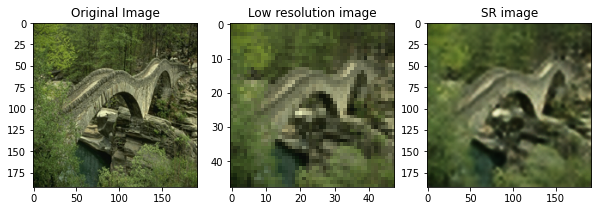

25/25 [==============================] - 24s 810ms/step - d_loss: 0.2000 - g_loss: 0.0795 - psnr: 25.2278 - val_d_loss: 0.1994 - val_g_loss: 0.0915 - val_psnr: 23.5938
Epoch 2/25
25/25 [==============================] - ETA: 0s - d_loss: 0.2027 - g_loss: 0.0807 - psnr: 25.1461

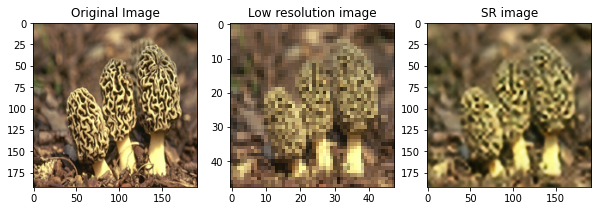

25/25 [==============================] - 22s 813ms/step - d_loss: 0.2027 - g_loss: 0.0807 - psnr: 25.1461 - val_d_loss: 0.2003 - val_g_loss: 0.0984 - val_psnr: 23.4176
Epoch 3/25
25/25 [==============================] - ETA: 0s - d_loss: 0.2302 - g_loss: 0.0796 - psnr: 25.2042

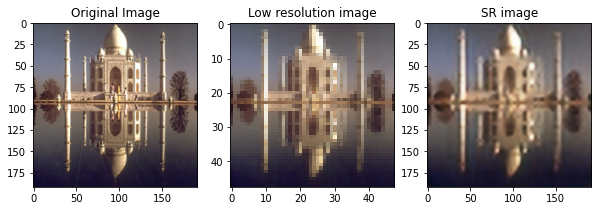

25/25 [==============================] - 22s 807ms/step - d_loss: 0.2302 - g_loss: 0.0796 - psnr: 25.2042 - val_d_loss: 0.2078 - val_g_loss: 0.0976 - val_psnr: 23.5597
Epoch 4/25
25/25 [==============================] - ETA: 0s - d_loss: 0.2127 - g_loss: 0.0787 - psnr: 25.2768

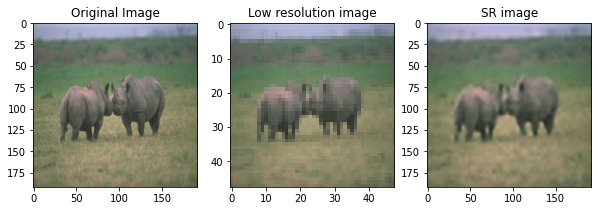

25/25 [==============================] - 22s 812ms/step - d_loss: 0.2127 - g_loss: 0.0787 - psnr: 25.2768 - val_d_loss: 0.2274 - val_g_loss: 0.0936 - val_psnr: 23.5424
Epoch 5/25
25/25 [==============================] - ETA: 0s - d_loss: 0.2569 - g_loss: 0.0785 - psnr: 25.2744

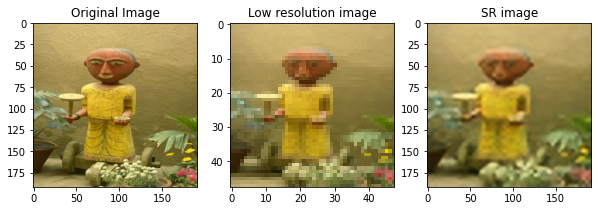

25/25 [==============================] - 22s 810ms/step - d_loss: 0.2569 - g_loss: 0.0785 - psnr: 25.2744 - val_d_loss: 0.2223 - val_g_loss: 0.0912 - val_psnr: 23.5663
Epoch 6/25
25/25 [==============================] - ETA: 0s - d_loss: 0.2314 - g_loss: 0.0770 - psnr: 25.3981

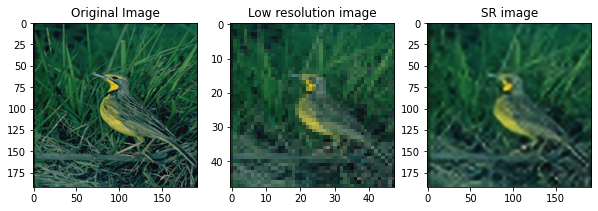

25/25 [==============================] - 22s 817ms/step - d_loss: 0.2314 - g_loss: 0.0770 - psnr: 25.3981 - val_d_loss: 0.2031 - val_g_loss: 0.0903 - val_psnr: 23.6684
Epoch 7/25
25/25 [==============================] - ETA: 0s - d_loss: 0.2201 - g_loss: 0.0770 - psnr: 25.3934

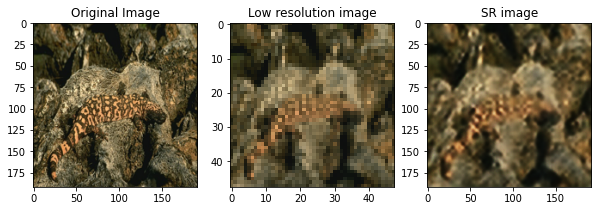

25/25 [==============================] - 22s 816ms/step - d_loss: 0.2201 - g_loss: 0.0770 - psnr: 25.3934 - val_d_loss: 0.2000 - val_g_loss: 0.0923 - val_psnr: 23.6377
Epoch 8/25
25/25 [==============================] - ETA: 0s - d_loss: 0.2180 - g_loss: 0.0770 - psnr: 25.4067

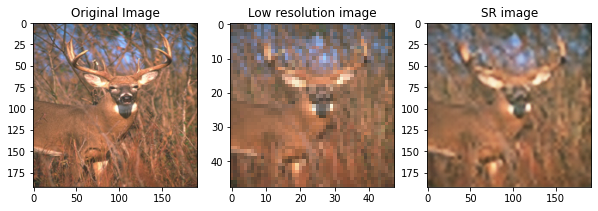

25/25 [==============================] - 22s 818ms/step - d_loss: 0.2180 - g_loss: 0.0770 - psnr: 25.4067 - val_d_loss: 0.2011 - val_g_loss: 0.0923 - val_psnr: 23.6362
Epoch 9/25
25/25 [==============================] - ETA: 0s - d_loss: 0.2309 - g_loss: 0.0763 - psnr: 25.4456

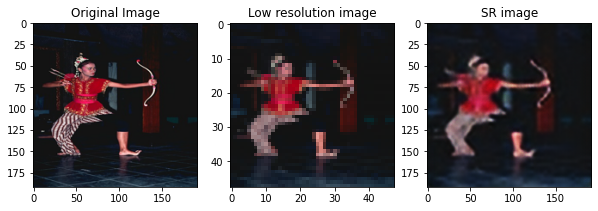

25/25 [==============================] - 23s 843ms/step - d_loss: 0.2309 - g_loss: 0.0763 - psnr: 25.4456 - val_d_loss: 0.2150 - val_g_loss: 0.0907 - val_psnr: 23.6584
Epoch 10/25
25/25 [==============================] - ETA: 0s - d_loss: 0.2116 - g_loss: 0.0772 - psnr: 25.4001

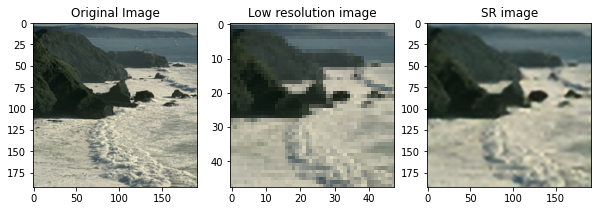

25/25 [==============================] - 23s 842ms/step - d_loss: 0.2116 - g_loss: 0.0772 - psnr: 25.4001 - val_d_loss: 0.2022 - val_g_loss: 0.0936 - val_psnr: 23.6653
Epoch 11/25
25/25 [==============================] - ETA: 0s - d_loss: 0.2138 - g_loss: 0.0771 - psnr: 25.4148

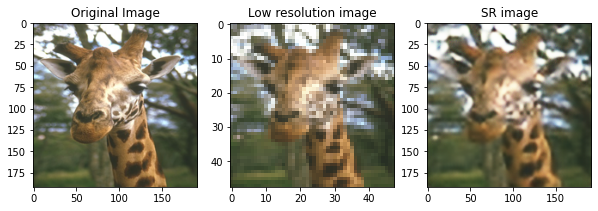

25/25 [==============================] - 22s 825ms/step - d_loss: 0.2138 - g_loss: 0.0771 - psnr: 25.4148 - val_d_loss: 0.2046 - val_g_loss: 0.0913 - val_psnr: 23.6937
Epoch 12/25
25/25 [==============================] - ETA: 0s - d_loss: 0.2090 - g_loss: 0.0764 - psnr: 25.4553

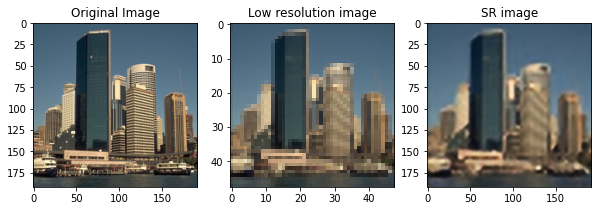

25/25 [==============================] - 22s 822ms/step - d_loss: 0.2090 - g_loss: 0.0764 - psnr: 25.4553 - val_d_loss: 0.2008 - val_g_loss: 0.0953 - val_psnr: 23.6792
Epoch 13/25
25/25 [==============================] - ETA: 0s - d_loss: 0.2230 - g_loss: 0.0769 - psnr: 25.4228

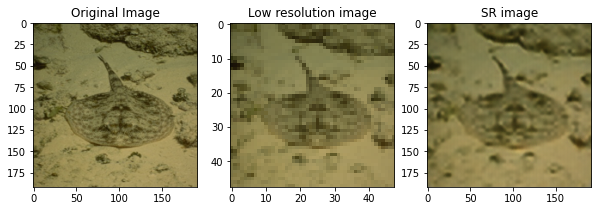

25/25 [==============================] - 22s 815ms/step - d_loss: 0.2230 - g_loss: 0.0769 - psnr: 25.4228 - val_d_loss: 0.2043 - val_g_loss: 0.0953 - val_psnr: 23.6821
Epoch 14/25
25/25 [==============================] - ETA: 0s - d_loss: 0.2149 - g_loss: 0.0779 - psnr: 25.3807

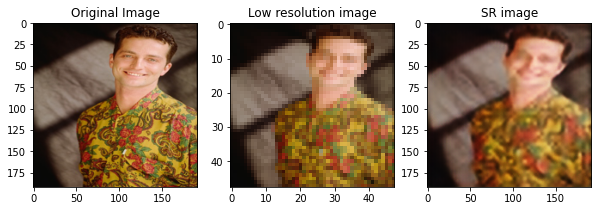

25/25 [==============================] - 22s 820ms/step - d_loss: 0.2149 - g_loss: 0.0779 - psnr: 25.3807 - val_d_loss: 0.2004 - val_g_loss: 0.0953 - val_psnr: 23.6500
Epoch 15/25
25/25 [==============================] - ETA: 0s - d_loss: 0.2187 - g_loss: 0.0767 - psnr: 25.4462

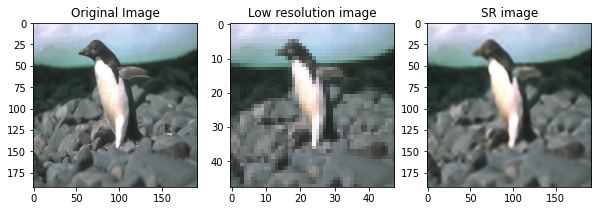

25/25 [==============================] - 23s 850ms/step - d_loss: 0.2187 - g_loss: 0.0767 - psnr: 25.4462 - val_d_loss: 0.2042 - val_g_loss: 0.0886 - val_psnr: 23.6823
Epoch 16/25
25/25 [==============================] - ETA: 0s - d_loss: 0.2329 - g_loss: 0.0766 - psnr: 25.4360

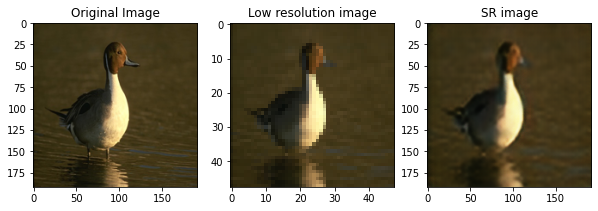

25/25 [==============================] - 22s 823ms/step - d_loss: 0.2329 - g_loss: 0.0766 - psnr: 25.4360 - val_d_loss: 0.2146 - val_g_loss: 0.0896 - val_psnr: 23.7012
Epoch 17/25
25/25 [==============================] - ETA: 0s - d_loss: 0.2199 - g_loss: 0.0762 - psnr: 25.4808

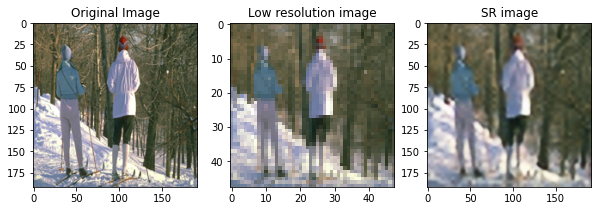

25/25 [==============================] - 22s 824ms/step - d_loss: 0.2199 - g_loss: 0.0762 - psnr: 25.4808 - val_d_loss: 0.1999 - val_g_loss: 0.0890 - val_psnr: 23.6967
Epoch 18/25
25/25 [==============================] - ETA: 0s - d_loss: 0.2191 - g_loss: 0.0760 - psnr: 25.5021

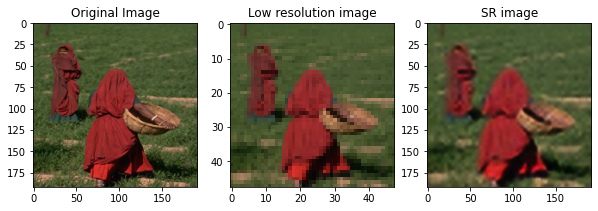

25/25 [==============================] - 22s 827ms/step - d_loss: 0.2191 - g_loss: 0.0760 - psnr: 25.5021 - val_d_loss: 0.2020 - val_g_loss: 0.0935 - val_psnr: 23.7036
Epoch 19/25
25/25 [==============================] - ETA: 0s - d_loss: 0.2064 - g_loss: 0.0785 - psnr: 25.3418

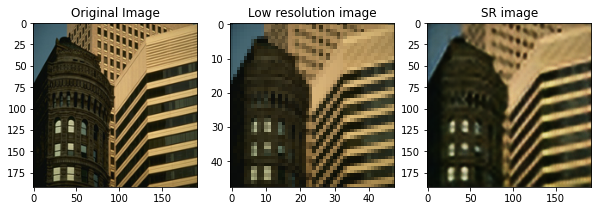

25/25 [==============================] - 22s 832ms/step - d_loss: 0.2064 - g_loss: 0.0785 - psnr: 25.3418 - val_d_loss: 0.1993 - val_g_loss: 0.0913 - val_psnr: 23.6815
Epoch 20/25
25/25 [==============================] - ETA: 0s - d_loss: 0.2051 - g_loss: 0.0769 - psnr: 25.4484

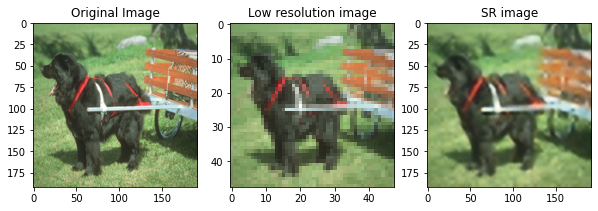

25/25 [==============================] - 22s 819ms/step - d_loss: 0.2051 - g_loss: 0.0769 - psnr: 25.4484 - val_d_loss: 0.2012 - val_g_loss: 0.0928 - val_psnr: 23.7166
Epoch 21/25
25/25 [==============================] - ETA: 0s - d_loss: 0.2030 - g_loss: 0.0757 - psnr: 25.5405

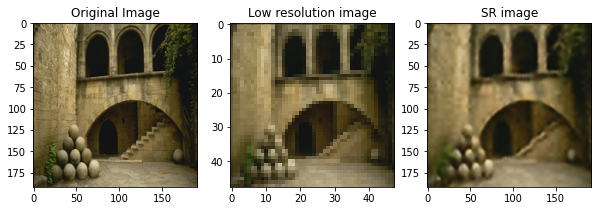

25/25 [==============================] - 22s 824ms/step - d_loss: 0.2030 - g_loss: 0.0757 - psnr: 25.5405 - val_d_loss: 0.2013 - val_g_loss: 0.0962 - val_psnr: 23.6905
Epoch 22/25
25/25 [==============================] - ETA: 0s - d_loss: 0.2066 - g_loss: 0.0765 - psnr: 25.4712

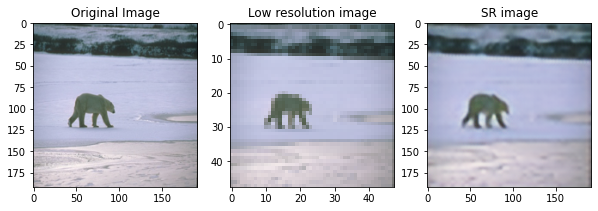

25/25 [==============================] - 22s 824ms/step - d_loss: 0.2066 - g_loss: 0.0765 - psnr: 25.4712 - val_d_loss: 0.2009 - val_g_loss: 0.0956 - val_psnr: 23.6778
Epoch 23/25
25/25 [==============================] - ETA: 0s - d_loss: 0.2699 - g_loss: 0.0762 - psnr: 25.4860

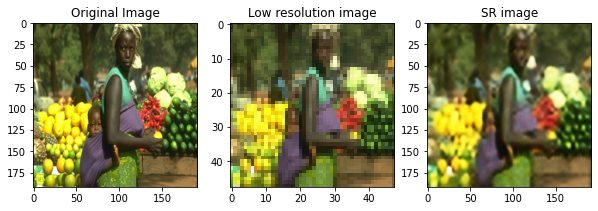

25/25 [==============================] - 22s 823ms/step - d_loss: 0.2699 - g_loss: 0.0762 - psnr: 25.4860 - val_d_loss: 0.2067 - val_g_loss: 0.0941 - val_psnr: 23.6992
Epoch 24/25
25/25 [==============================] - ETA: 0s - d_loss: 0.2341 - g_loss: 0.0763 - psnr: 25.4804

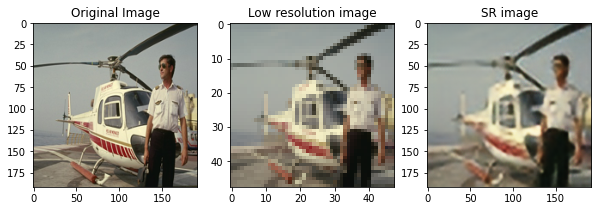

25/25 [==============================] - 22s 821ms/step - d_loss: 0.2341 - g_loss: 0.0763 - psnr: 25.4804 - val_d_loss: 0.2032 - val_g_loss: 0.0939 - val_psnr: 23.6804
Epoch 25/25
25/25 [==============================] - ETA: 0s - d_loss: 0.2216 - g_loss: 0.0770 - psnr: 25.4715

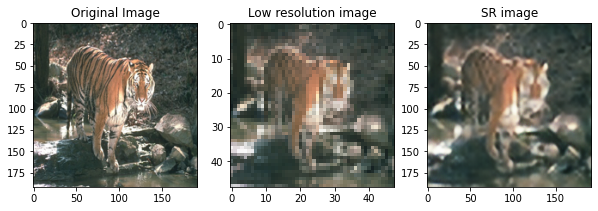

25/25 [==============================] - 22s 826ms/step - d_loss: 0.2216 - g_loss: 0.0770 - psnr: 25.4715 - val_d_loss: 0.2096 - val_g_loss: 0.0903 - val_psnr: 23.7151


In [58]:
history = model.fit(train_ds, epochs=100, validation_data=valid_ds, callbacks=callbacks, verbose=1)

In [ ]:
# perceptual loss?
# more images!!!, increase low resolution

**WGAN-GP** experimental (fixed gradient penalty nan)

In [77]:
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

class SRGAN(tf.keras.Model):
    def __init__(self, discriminator_extra_steps=3, gp_weight=10.0):
        super(SRGAN, self).__init__()
        self.generator = generator()
        self.discriminator = discriminator()

        self.discriminator_extra_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, *args, **kwargs):
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

        self.d_loss_fn = discriminator_loss
        self.g_loss_fn = generator_loss

        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")
        self.psnr = tf.keras.metrics.Mean(name="psnr")
        super(SRGAN, self).compile(*args, **kwargs)

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric, self.psnr]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]) + 1e-12)
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, inputs):
        lr_images, hr_images = inputs
        batch_size = tf.shape(lr_images)[0]

        for _ in range(self.discriminator_extra_steps):
            with tf.GradientTape() as d_tape:
                gen_images = self.generator(lr_images, training=True)
                fake_pred = self.discriminator(gen_images, training=True)
                real_pred = self.discriminator(hr_images, training=True)

                d_cost = self.d_loss_fn(real_img=real_pred, fake_img=fake_pred)
                gp = self.gradient_penalty(batch_size, hr_images, gen_images)

                d_loss = d_cost + gp * self.gp_weight

            gradients = d_tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_weights))

        with tf.GradientTape() as g_tape:
            gen_images = self.generator(lr_images, training=True)
            pred_fake = self.discriminator(gen_images, training=True)
            
            g_loss = self.g_loss_fn(pred_fake)

        gradients = g_tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_weights))        

        psnr_value = psnr(denormalize(hr_images), denormalize(gen_images))
        self.psnr.update_state(psnr_value)
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
            "psnr": self.psnr.result(),
        }

    def test_step(self, inputs):
        lr_images, hr_images = inputs

        gen_images = self.generator(lr_images, training=False)
        fake_pred = self.discriminator(gen_images, training=False)
        real_pred = self.discriminator(hr_images, training=False)

        g_loss = self.g_loss_fn(fake_pred)

        psnr_value = psnr(denormalize(hr_images), denormalize(gen_images))

        d_loss = self.d_loss_fn(real_img=real_pred, fake_img=fake_pred)

        self.psnr.update_state(psnr_value)
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
            "psnr": self.psnr.result(),
        }

    def call(self, lr_images):
        out = self.generator(lr_images)
        out = denormalize(out)
        return out.numpy()

In [78]:
model = SRGAN()
model.compile(d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9, clipnorm=1.),
              g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9, clipnorm=1.),
              run_eagerly=False)

callbacks = [
             tf.keras.callbacks.LambdaCallback(on_epoch_end=plot_samples),
             tf.keras.callbacks.ModelCheckpoint(f"checkpoints/srgan.ckpt", save_weights_only=True, verbose=0),
            ]

Epoch 1/100
25/25 [==============================] - ETA: 0s - d_loss: 9.9471 - g_loss: -5.9174e-04 - psnr: 10.7298

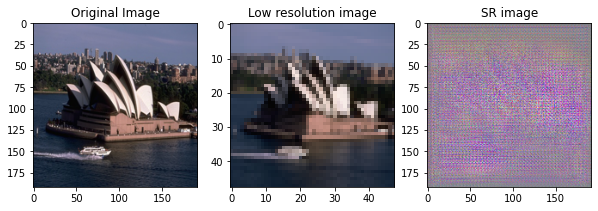

25/25 [==============================] - 108s 3s/step - d_loss: 9.9471 - g_loss: -5.9174e-04 - psnr: 10.7298 - val_d_loss: -5.2225e-22 - val_g_loss: 0.0000e+00 - val_psnr: 10.2882
Epoch 2/100


KeyboardInterrupt: ignored

In [79]:
history = model.fit(train_ds, epochs=100, validation_data=valid_ds, callbacks=callbacks, verbose=1)